In [1]:
### **Imports and data loading**
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

In [3]:
# Load dataset into dataframe
data = pd.read_csv(r"C:\Users\nguye\Downloads\tiktok_dataset.csv")

In [4]:
# Check class balance
data['claim_status'].value_counts(normalize=True)

claim      0.503458
opinion    0.496542
Name: claim_status, dtype: float64

In [28]:
# Drop rows with missing values
data = data.dropna(axis=0)

Approximately 50.3% of the dataset represents claims and 49.7% represents opinions, so the outcome variable is balanced.

### **Feature engineering**

Extract the length (character count) of each `video_transcription_text` and add this to the dataframe as a new column called `text_length` so that it can be used as a feature in the model.

In [29]:
# Create text_length column
data['text_length'] = data['video_transcription_text'].str.len()
data.head()


,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


Calculate the average `text_length` for claims and opinions.

In [30]:
data.groupby('claim_status').mean()['text_length'].reset_index()

,claim_status,text_length
0,claim,95.376978
1,opinion,82.722562


Visualize the distribution of `text_length` for claims and opinions using a histogram.

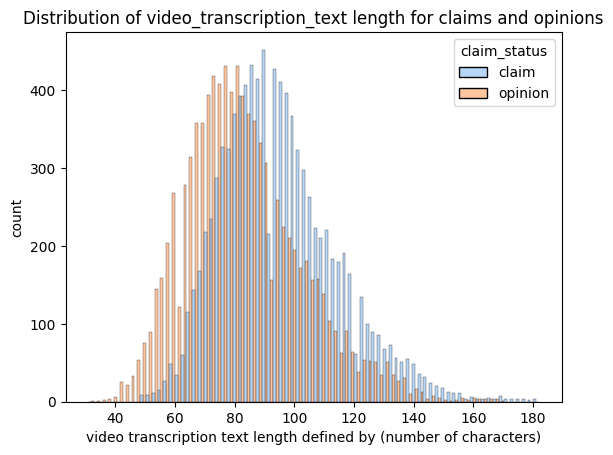

In [31]:
# Visualize the distribution of `text_length` for claims and opinions
# Create two histograms in one plot

sns.histplot(data = data, stat= 'count', multiple= 'dodge', x = 'text_length',
             kde=False, palette= 'pastel', hue= 'claim_status')
plt.xlabel('video transcription text length defined by (number of characters)')
plt.ylabel('count')
plt.title('Distribution of video_transcription_text length for claims and opinions')
plt.show()

Letter count distributions for both claims and opinions are approximately normal with a slight right skew. Claim videos tend to have more characters&mdash;about 13 more on average, as indicated in a previous cell.

**Feature selection and transformation**

Encode target and catgorical variables.

In [32]:
X = data.copy()
# Drop unnecessary columns
X = X.drop(['#', 'video_id'], axis= 1)

# Encode target variable
X['claim_status'] = X['claim_status'].replace({'opinion' : 0, 'claim' : 1})

# Dummy encode remainning categorical values 

X = pd.get_dummies(X, columns=['verified_status','author_ban_status'], drop_first= True)

X.head()

,claim_status,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1
1,1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,1,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0
3,1,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0
4,1,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0


### **Split the data**

Assign target variable.

In this case, the target variable is `claim_status`.
* 0 represents an opinion
* 1 represents a claim

In this case, the model is going to take smaller variable as 0 as negative, and vice versus. 

In [78]:
#check again the balance of the dataset
data['claim_status'].value_counts()

# it shows this one is nearly balanced between the target variable

claim      9608
opinion    9476
Name: claim_status, dtype: int64

In [33]:
# Isolate target variable
y = X['claim_status']

In [34]:
#Isolate features
X = X.drop(['claim_status'], axis=1)

# Display first few rows
X.head()

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0
3,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0
4,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0


#### **Create train/validate/test sets**

Split data into training and testing sets, 80/20.

In [35]:
# split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size= 0.2, random_state=0)

Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [36]:
# split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size= 0.25, random_state= 0)

Confirm that the dimensions of the training, validation, and testing sets are in alignment.

In [37]:
# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 11), (3817, 11), (3817, 11), (11450,), (3817,), (3817,))

### **Tokenize text column**

In [38]:
# set up a ConVectorizer object, which converts a collection of text to a matrix of token  counts
count_vec = CountVectorizer(ngram_range=(2,3), max_features= 15, stop_words= 'english')

Fit the vectorize to the training data (generate the n-grams) and tranform it. Only fit to the training data, not the validation or test data

In [62]:
# Extract the numerical features from video_transcription_text in the training set
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_data


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [47]:
# Place the numerical representation of video_transcription_text from training set into a dataframe
count_df = pd.DataFrame(data= count_data, columns=count_vec.get_feature_names_out())

count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
# Concatenate X_train and count_df to form the final data frame for training data named X_train_final
X_train_final= pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True),count_df],axis = 1)

X_train_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,51,2487.0,310.0,20.0,1.0,0.0,134,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,43,118512.0,3543.0,374.0,70.0,29.0,97,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,22,105902.0,1885.0,229.0,39.0,9.0,76,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,17,9245.0,1670.0,440.0,13.0,4.0,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,18,3791.0,660.0,63.0,9.0,1.0,57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Get n-gram counts for the validation data.The vectorizer is not being refit to the validation data. It's only transforming it. The transcriptions of the videos in the validation data are only being checked against the n-grams found in the training data. It prenvents data leaks, and over-fitting

In [56]:
# Extract numerical feature from video_transcription_text in the testing set
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()

validation_count_data

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [87]:
# Place the numerical reprsentation of video_trainscription_text from validation set into a dataframe
validation_count_df = pd.DataFrame(data=validation_count_data,columns=count_vec.get_feature_names_out())

validation_count_df.head()
X_val_final = pd.concat([X_val.drop(columns='video_transcription_text').reset_index(drop=True),validation_count_df], axis = 1)
X_val_final.head()

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,11,578891.0,379596.0,14612.0,6591.0,44.0,72,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,24,6255.0,1709.0,311.0,13.0,1.0,96,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,35,410356.0,249714.0,26235.0,2060.0,1252.0,88,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,58,406911.0,25986.0,1230.0,564.0,248.0,83,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,47,972573.0,138167.0,25320.0,3331.0,968.0,104,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


Repeat the same process to get n-gram counts for the test data

In [68]:
# Extract numerical feature from video_transcription_text in the testing set
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

#place to dataframe
test_count_df = pd.DataFrame(data = test_count_data, columns=count_vec.get_feature_names_out())

#Concatenate test_count_df with X_test named it X_test_final
X_test_final = pd.concat([X_test.drop(columns='video_transcription_text').reset_index(drop=True),
                          test_count_df], axis=1)

X_test_final.head()


,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,54,692084.0,135956.0,16591.0,622.0,312.0,107,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
1,37,5164.0,1858.0,36.0,17.0,1.0,69,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,39,801951.0,344163.0,57608.0,8578.0,2942.0,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,44,6429.0,2314.0,847.0,17.0,5.0,76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,26,555780.0,106863.0,15348.0,252.0,91.0,72,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **Build models**

### **Build a random forest model**

Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [73]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth' : [5,7,None],
             'max_features': [0.3, 0.6],
             # max_features  = auto
             'max_samples' : [0.7],
             'min_samples_leaf' : [1,2],
             'min_samples_split' : [2,3],
             'n_estimators' : [75,100,200],}

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy','precision','recall','f1'}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf,cv_params,scoring=scoring, cv=5,refit='recall')

In [74]:
%%time
rf_cv.fit(X_train_final, y_train)

Wall time: 4min 50s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring={'precision', 'f1', 'recall', 'accuracy'})

In [75]:
# Examine best recall score
rf_cv.best_score_

0.9948228253467271

In [76]:
# Examine best parameters
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

This model performs exceptionally well, with an average recall score of 0.995 across the five cross-validation folds. After checking the precision score to be sure the model is not classifying all samples as claims, it is clear that this model is making almost perfect classifications.

### **Build an XGBoost model**

In [80]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective= 'binary:logistic', random_state = 0)

# Create a dictionary of hyperparameter to tune 
cv_params = {'max_depth' : [4,8,12],
             'min_child_weight' : [3,5],
             'learning_rate' : [0.01, 0.1],
             'n_estimators' : [300, 500]}

# Define a  dictionary of scoring metrics to capture 
scoring = {'accuracy','precision', 'recall','f1'}

# Instantiate the GridSearchCV object
xgb_cv= GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit= 'recall')

In [81]:
%%time
xgb_cv.fit(X_train_final, y_train)

Wall time: 2min 38s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                        

In [ ]:
#Examine the best score 
xgb_cv.best_score_

0.9906808769992594

In [83]:
#Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 300}

This model also performs exceptionally well. Although its recall score is very slightly lower than the random forest model's, its precision score is perfect.

### **Evaluate models**

Evaluate models against validation data.


#### **Random forest**

In [89]:
# Use the random forest 'best estimator' model to get predictions on the validation set
y_pred = rf_cv.best_estimator_.predict(X_val_final)
y_pred

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

Create a confusion matrix to visualize the results of the classification model.

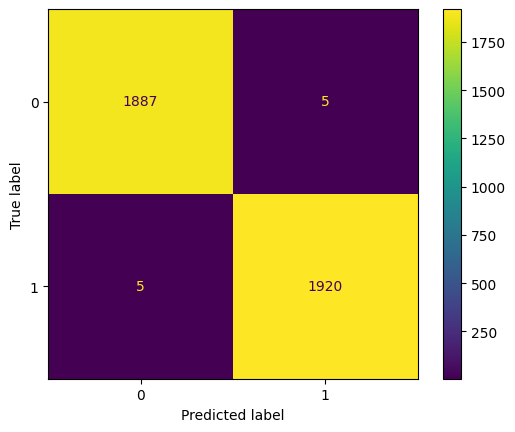

In [100]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_val,y_pred)
# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix= log_cm, display_labels=None)

# plot confusion matrix
log_disp.plot()

plt.show()

The upper-left [0 0] quadrant displays the number of true negatives: the number of opinions that the model accurately classified as so.

The upper-right [0 1] quadrant displays the number of false positives: the number of opinions that the model misclassified as claims.

The lower-left [1 0] quadrant displays the number of false negatives: the number of claims that the model misclassified as opinions.

The lower-right [1 1] quadrant displays the number of true positives: the number of claims that the model accurately classified as so.


In [103]:
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))


              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



#### **XGBoost**

evaluate the XGBoost model on the validation set.

In [105]:
#Evaluate XGBoost model
y_pred_xgb = xgb_cv.best_estimator_.predict(X_val_final)
y_pred_xgb

array([1, 0, 1, ..., 1, 1, 1])

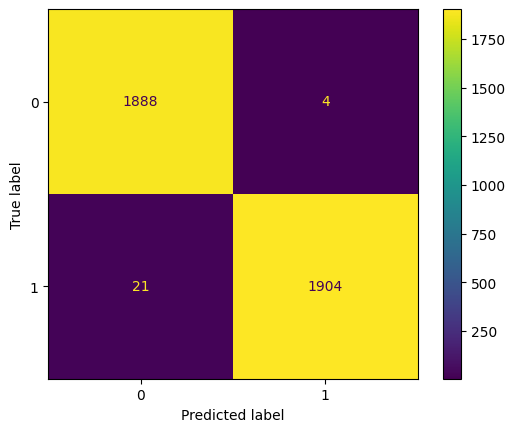

In [106]:
# Compute values for confusion matrix
log_cm_xgb = confusion_matrix(y_val,y_pred_xgb)

#Create display of confusion matrix

log_cm_xgb_display = ConfusionMatrixDisplay(confusion_matrix= log_cm_xgb, display_labels= None)

log_cm_xgb_display.plot()

In [108]:
# Create a classification report 
print(classification_report(y_val,y_pred_xgb, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



The results of the XGBoost model were also nearly perfect. However, its errors tended to be false negatives. Identifying claims was the priority, so it's important that the model be good at capturing all actual claim videos. The random forest model has a better recall score, and is therefore the champion model.

### **Use champion model to predict on test data**

Both random forest and XGBoost model architectures resulted in nearly perfect models. Nonetheless, in this case random forest performed a little bit better, so it is the champion model.

Now, use the champion model to predict on the test data.

In [ ]:
# Use champion model to predict on test data 

y_pre_final = rf_cv.best_estimator_.predict(X_test_final)


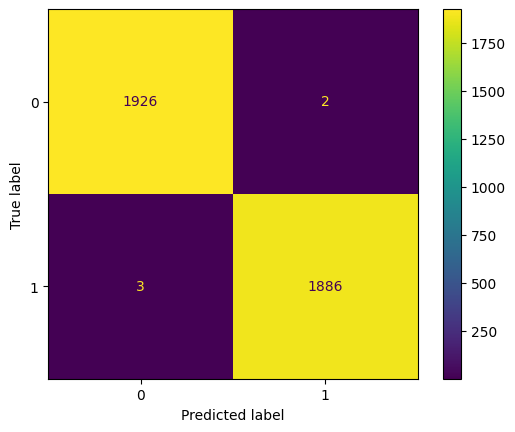

In [110]:
# Compute values for confuision matrix
log_cm_final = confusion_matrix( y_test, y_pre_final)

# create  display of confusion matrix
log_cm_final_display = ConfusionMatrixDisplay(confusion_matrix=log_cm_final, display_labels= None)
log_cm_final_display.plot()

#### **Feature importances of champion model**

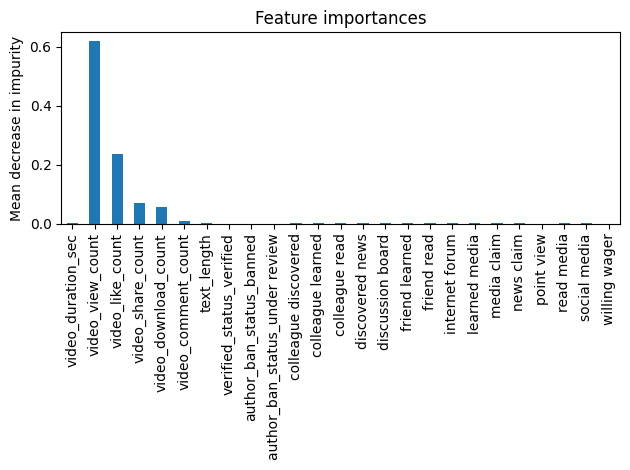

In [122]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances= pd.Series(importances, index=X_test_final.columns)
fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()


The most predictive features all were related to engagement levels generated by the video. This is not unexpected, as analysis from prior EDA pointed to this conclusion.

In [ ]:
# Import pickle library to store the pre-trained champion model
import pickle

In [124]:
# Save a model to a file 
with open('random_forest_model_tiktok.plk', 'wb') as f:
    pickle.dump(rf_cv.best_estimator_,f)


In [125]:
# to load back the model use:

# with open('random_forest_model_tiktok.plk,'rb'') as f:
#    loaded_model = pickle.load(f)

In [126]:
# save the processed dataset
X_train_final.to_csv('tiktok_processed_train.csv', index=False)